# Data Exploration

Importing Libraries

In [1]:
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
# Adjust the path to point to your scripts folder relative to the notebook
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
from src.data_loader import load_data
from src.plotter import Plotter

#### Loading Dataset

In [3]:
df = load_data('/Users/elbethelzewdie/Downloads/change_point_analysis_and_statistical_modeling/change_point_analysis_and_statistical_modeling/data/BrentOilPrices.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [4]:
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [5]:
df.tail()

,Date,Price
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37
9010,"Nov 14, 2022",93.59


#### Statistical Summary for the Price Column

In [6]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


- Summary statistics of daily Brent oil prices from 1987 to 2022 reveal substantial variability and right-skewness. While the average price over the period is approximately $48 per barrel, the median price is significantly lower at $38.6, indicating the influence of extreme high-price episodes. The large standard deviation of $32.9 and a maximum price of nearly $144 per barrel highlight the highly volatile nature of the oil market, underscoring the importance of volatility-focused and regime-based analytical approaches.

#### Data Type Correction

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

#### Visualizing the Dataset

In [8]:
plotter = Plotter()

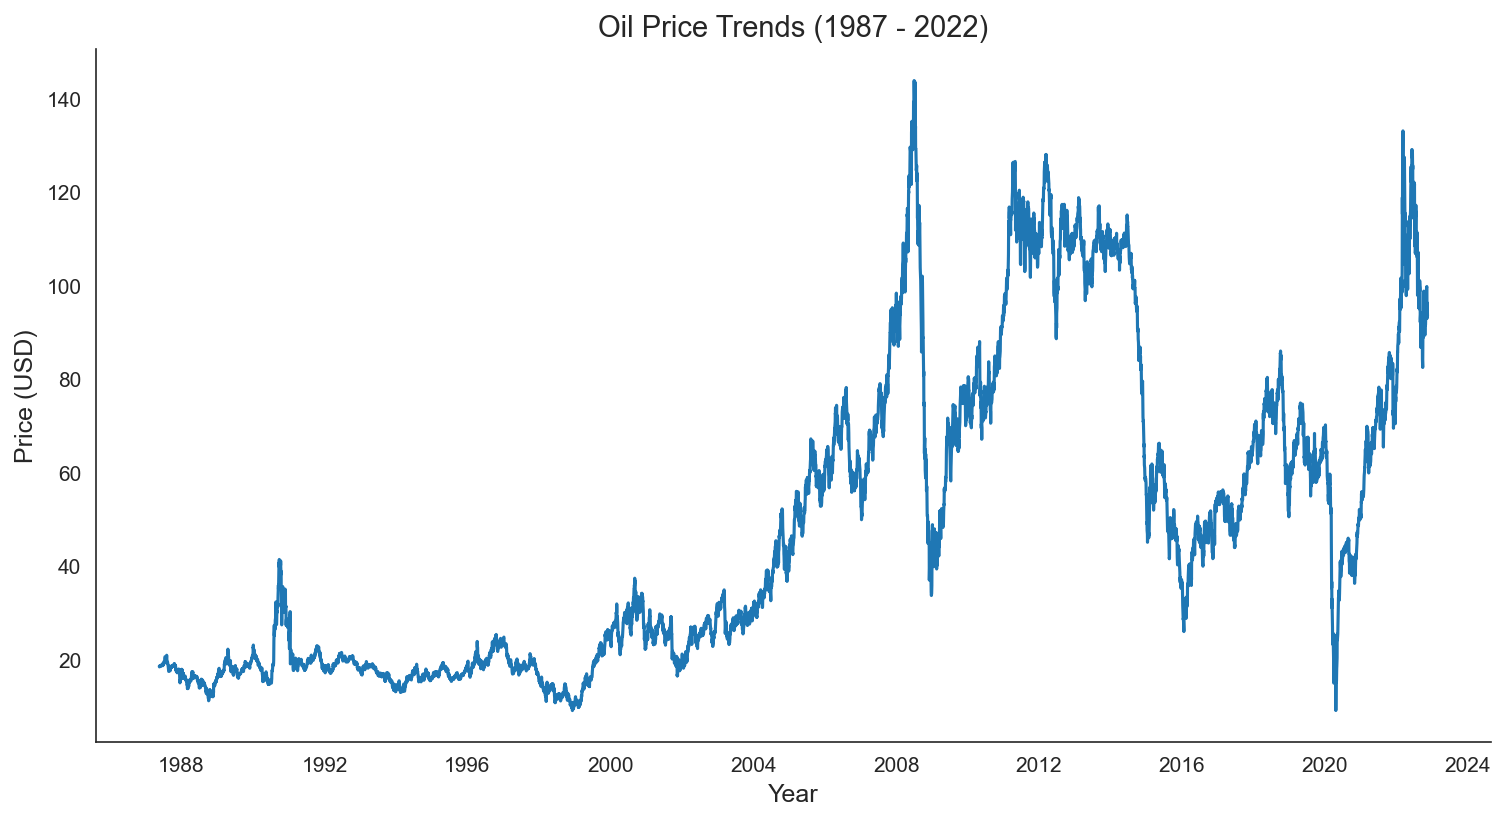

In [9]:
plotter.line_plot(
    data=df, 
    x='Date', 
    y='Price', 
    title='Oil Price Trends (1987 - 2022)',
    xlabel='Year',
    ylabel='Price (USD)'
)

From 1987–2022, the price series shows:

- Strong long-term trends

    - Flat/low regime (late 1980s–early 2000s)

    - Strong upward trend (2003–2008)

    - Multiple regime shifts afterward

- Changing variance

    - Small fluctuations before 2000

    - Very large swings after 2005

#### Seasonality and Trend Analysis

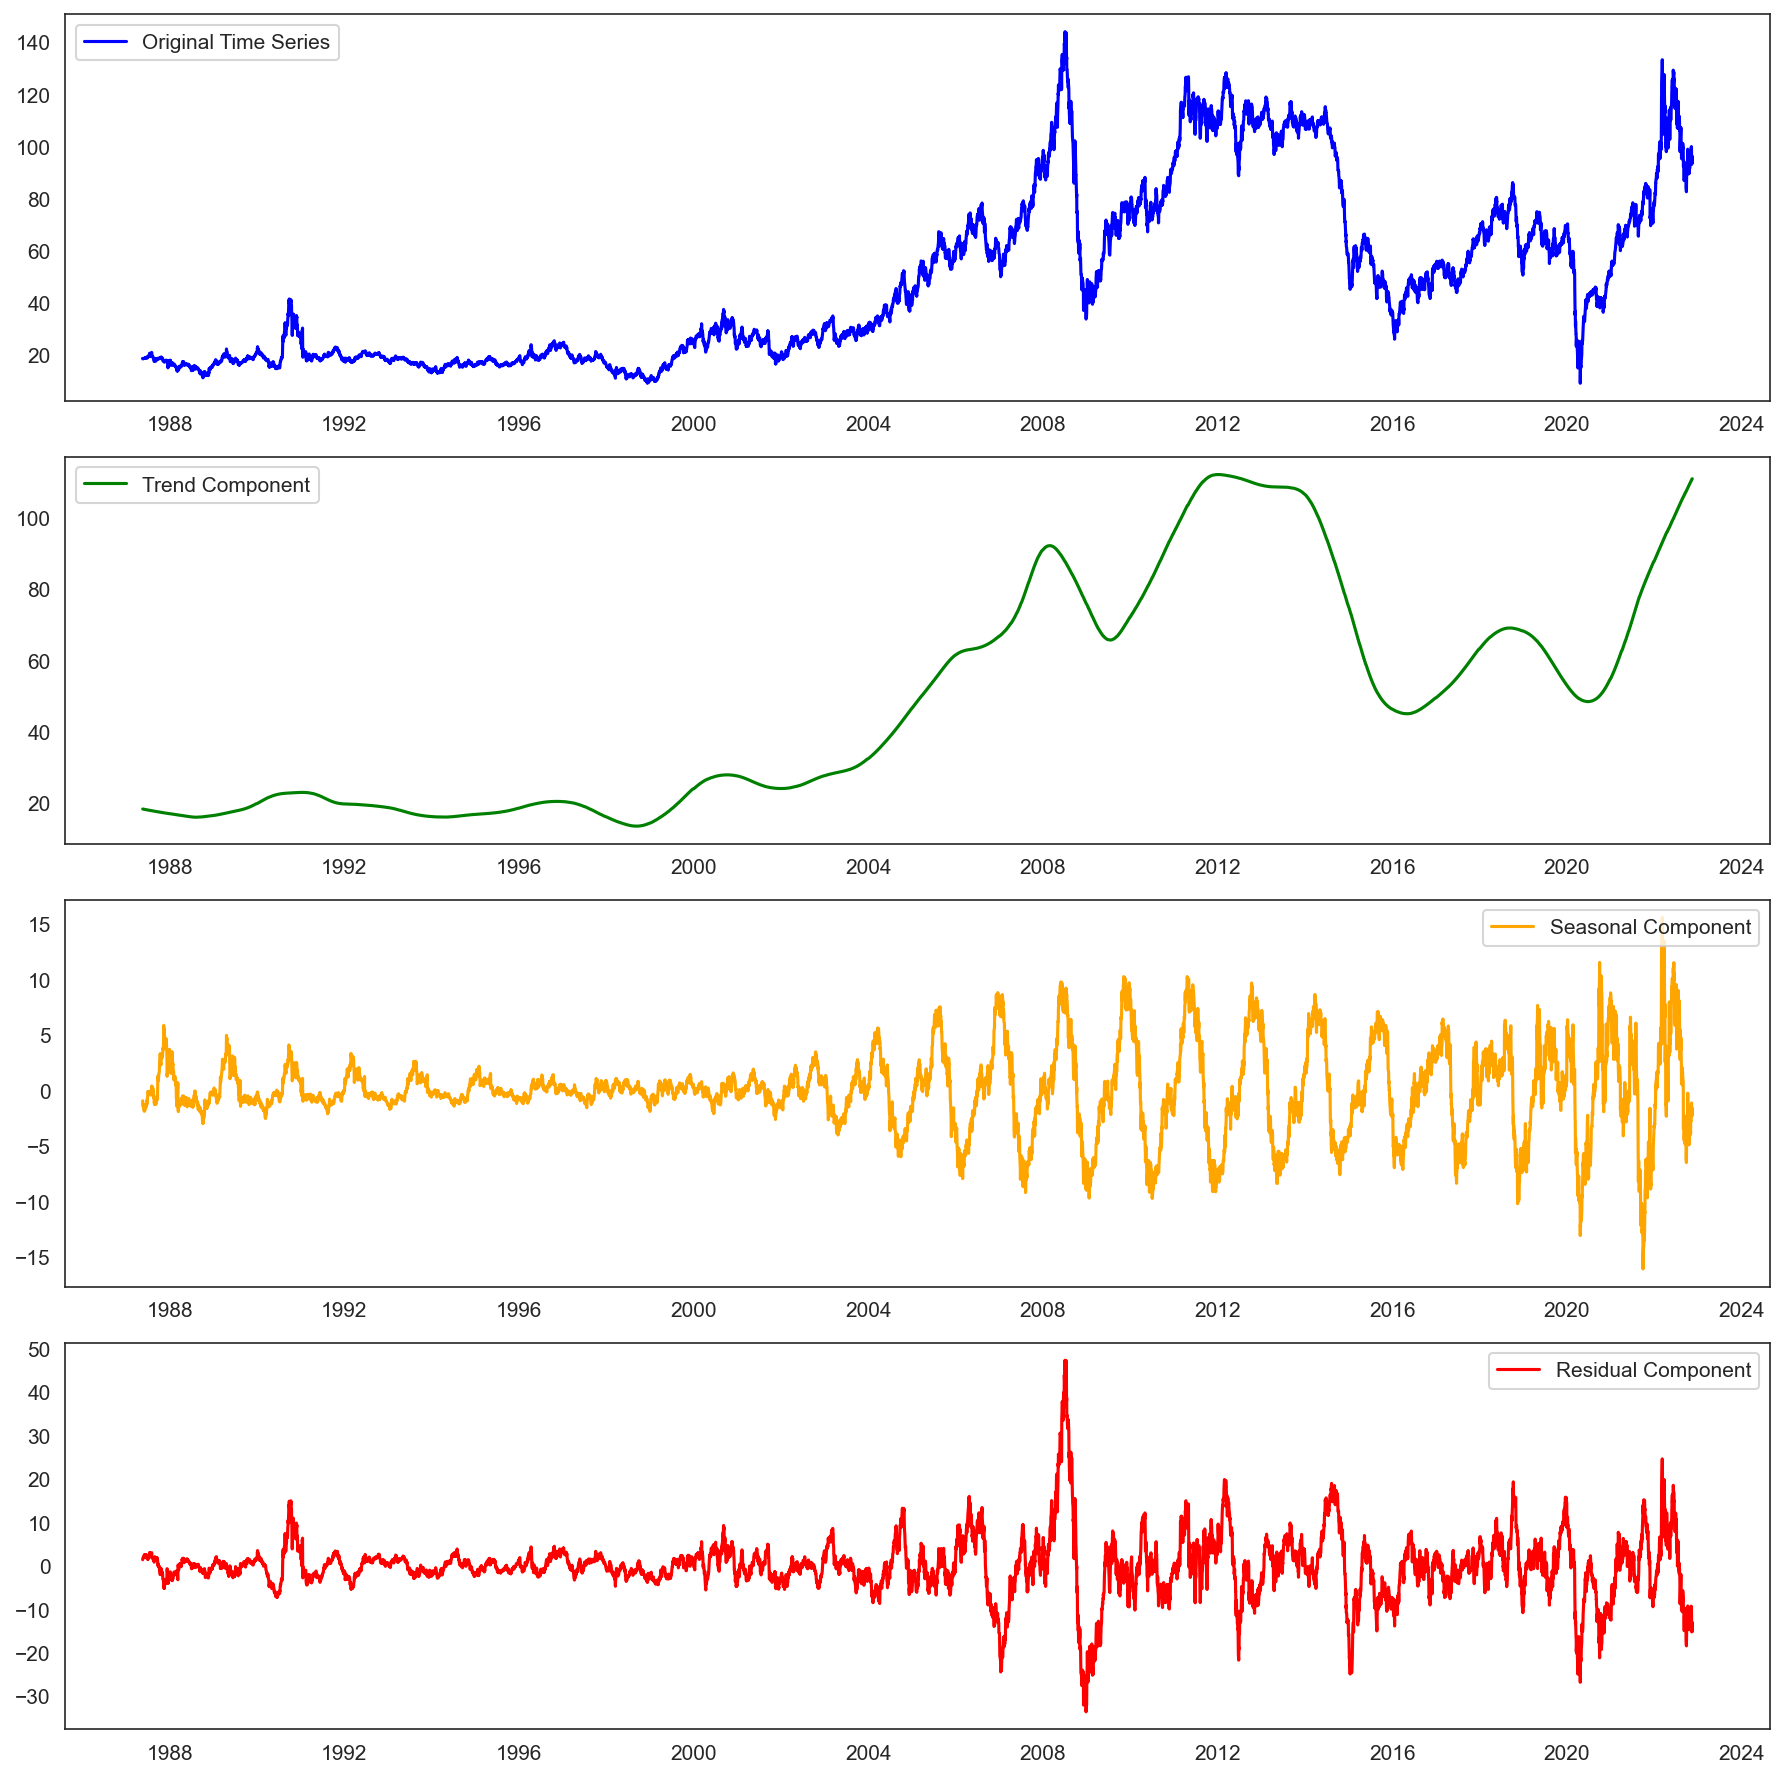

In [10]:
df_indexed = df.set_index('Date').sort_index()

# period=365 assumes you have daily data and want to find yearly patterns
plotter.decomposition_plot(df_indexed, value_col='Price', period=365)

#### Outlier Detection

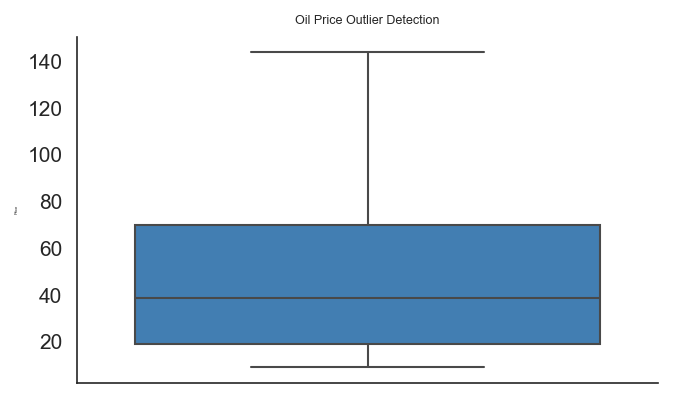

In [11]:
plotter.box_plot(df, y='Price', title='Oil Price Outlier Detection')

### Stationarity Testing

#### Augmented Dickey–Fuller (ADF) Test

- If p-value > 0.05
    - Non-stationary
- If p-value ≤ 0.05
    - Stationary

In [12]:
# Perform ADF test for stationarity
adf_result = adfuller(df_indexed["Price"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -1.9938560113924644
p-value: 0.2892735048934042


- The Price values are not stationary.

#### Transform to Log Returns

In [13]:
# Log-transform and difference to achieve stationarity
df_indexed["log_price"] = np.log(df_indexed["Price"])
df_indexed["log_return"] = df_indexed["log_price"].diff()

In [14]:
# Check stationarity of log returns
returns = df_indexed["log_return"].dropna()

In [15]:
adf_returns = adfuller(returns)

print("ADF Statistic (Returns):", adf_returns[0])
print("p-value (Returns):", adf_returns[1])


ADF Statistic (Returns): -16.42711349448592
p-value (Returns): 2.498580161142781e-29


- The Return values are stationary.

### Volatility Patterns

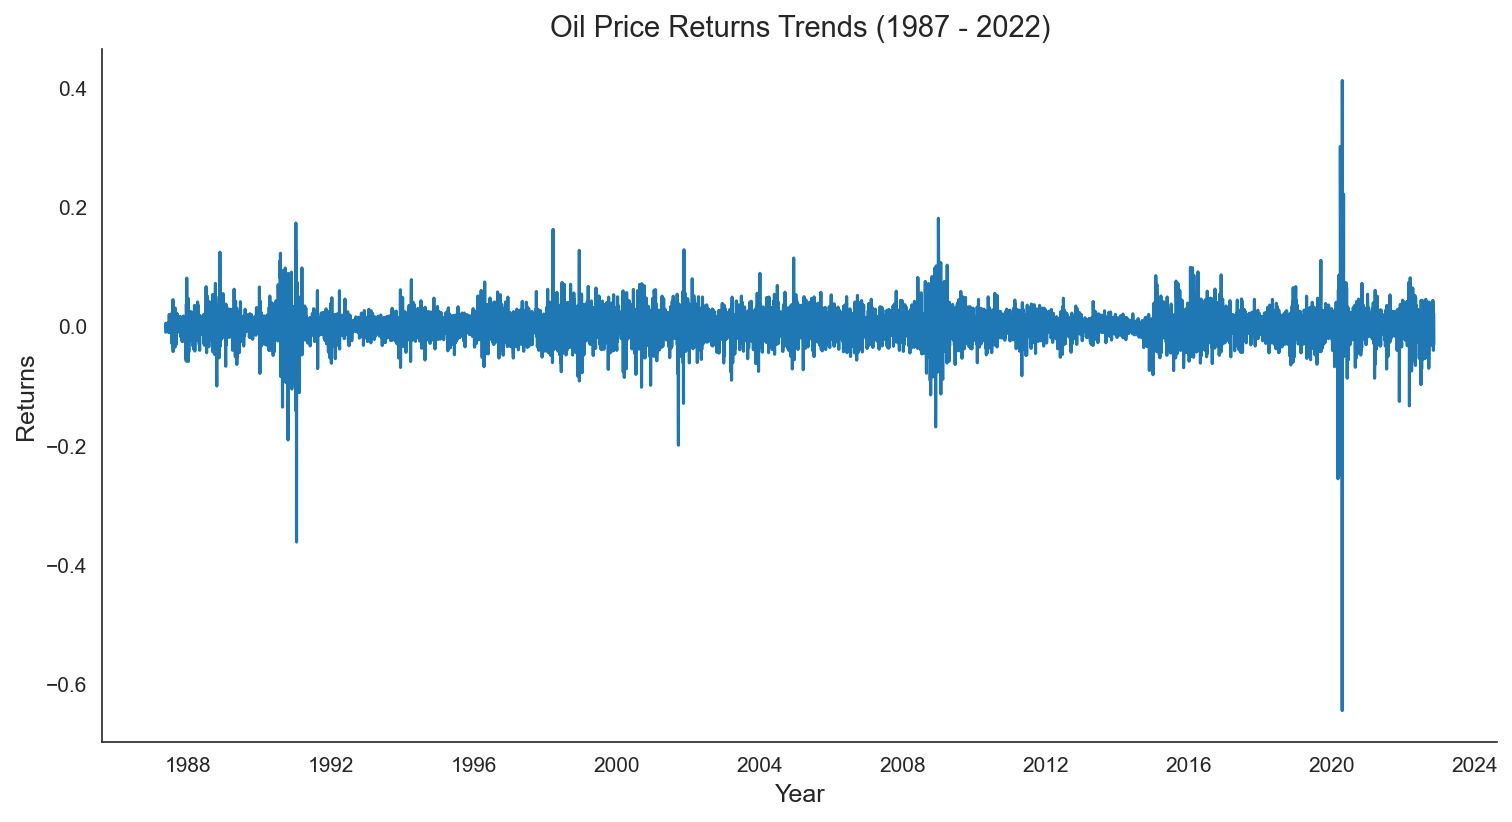

In [16]:
plotter.line_plot(
    data=df_indexed, 
    x='Date', 
    y=returns, 
    title='Oil Price Returns Trends (1987 - 2022)',
    xlabel='Year',
    ylabel='Returns'
)

#### Rolling Volatility

- Peaks → crises or shocks
- Plateaus → stable regimes

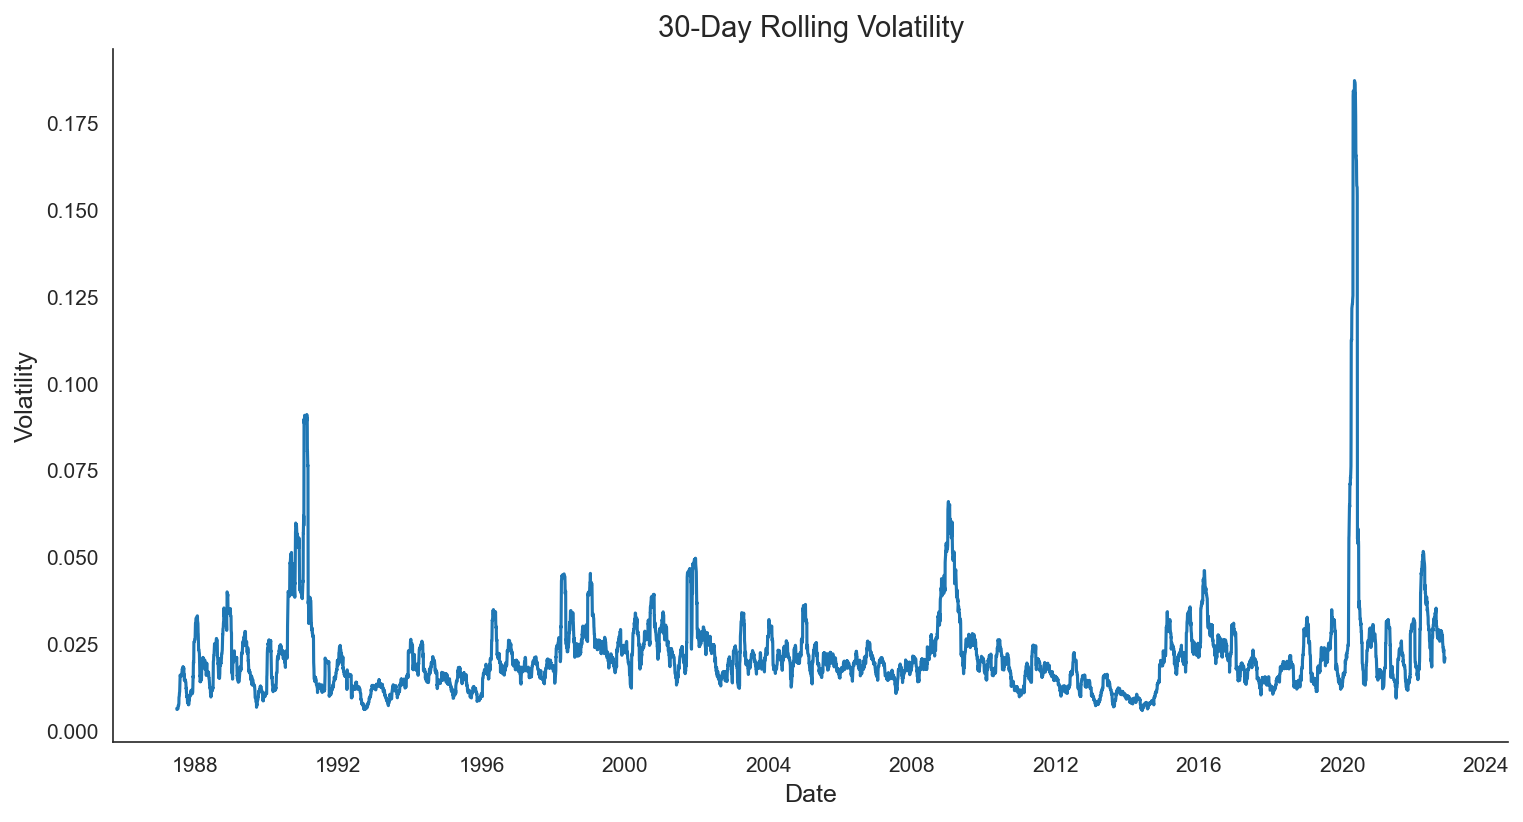

In [17]:
rolling_vol = returns.rolling(window=30).std()

plotter.line_plot(
    data=pd.DataFrame({'index': returns.index, 'rolling_vol': rolling_vol}),
    x='index',
    y='rolling_vol',
    title='30-Day Rolling Volatility',
    xlabel='Date',
    ylabel='Volatility'
)

#### Event Overlay

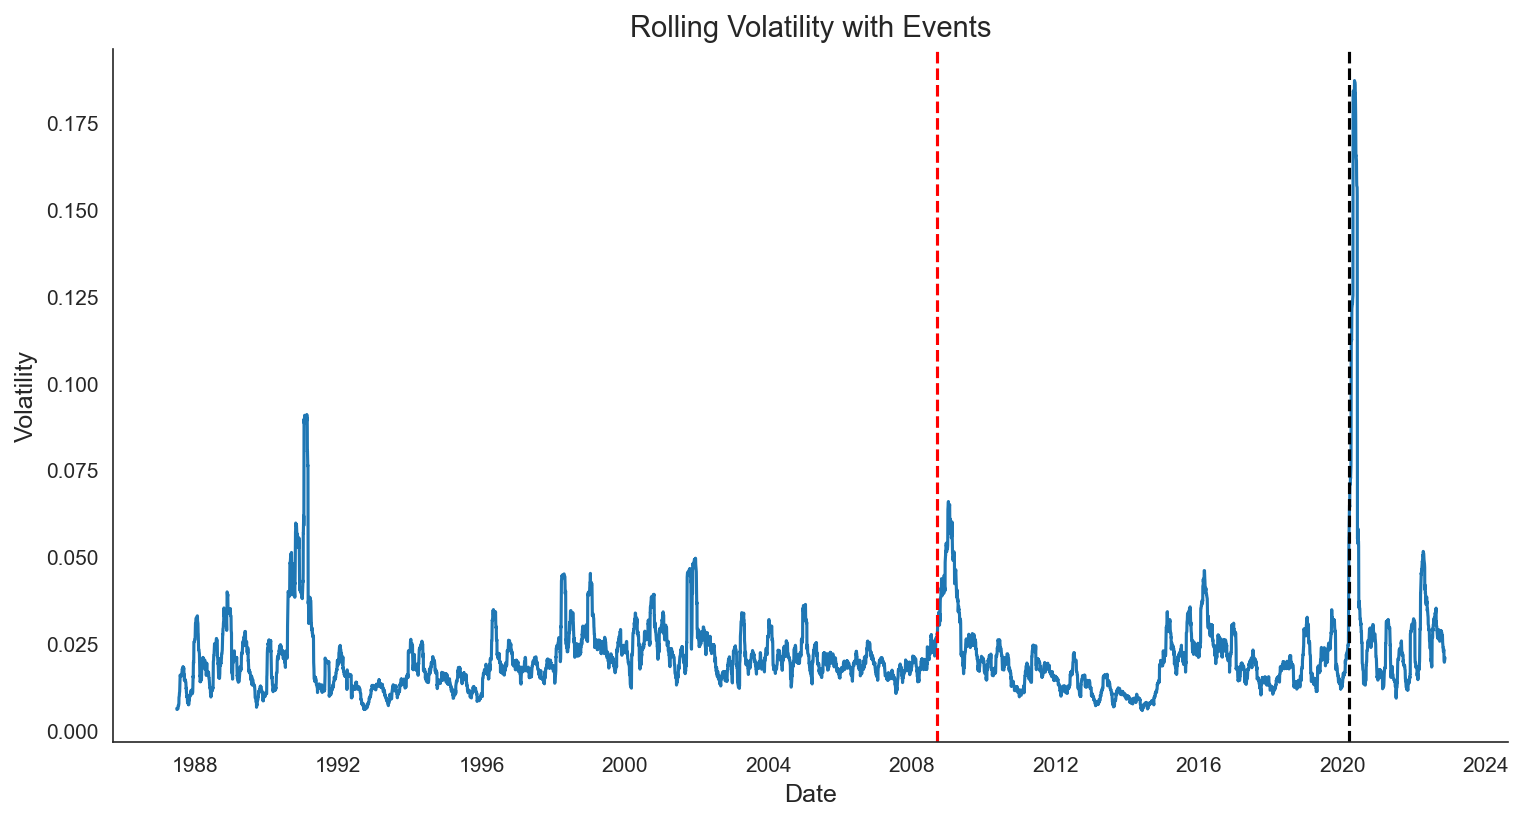

In [18]:
events = [
    {'date': '2008-09-15', 'color':'red', 'label':'GFC'},
    {'date': '2020-03-11', 'color':'black', 'label':'COVID'}
]

plotter.line_plot(
    data=pd.DataFrame({'Date': returns.index, 'Volatility': rolling_vol}),
    x='Date',
    y='Volatility',
    title='Rolling Volatility with Events',
    xlabel='Date',
    ylabel='Volatility',
    vlines=events
)


#### Distribution of Returns

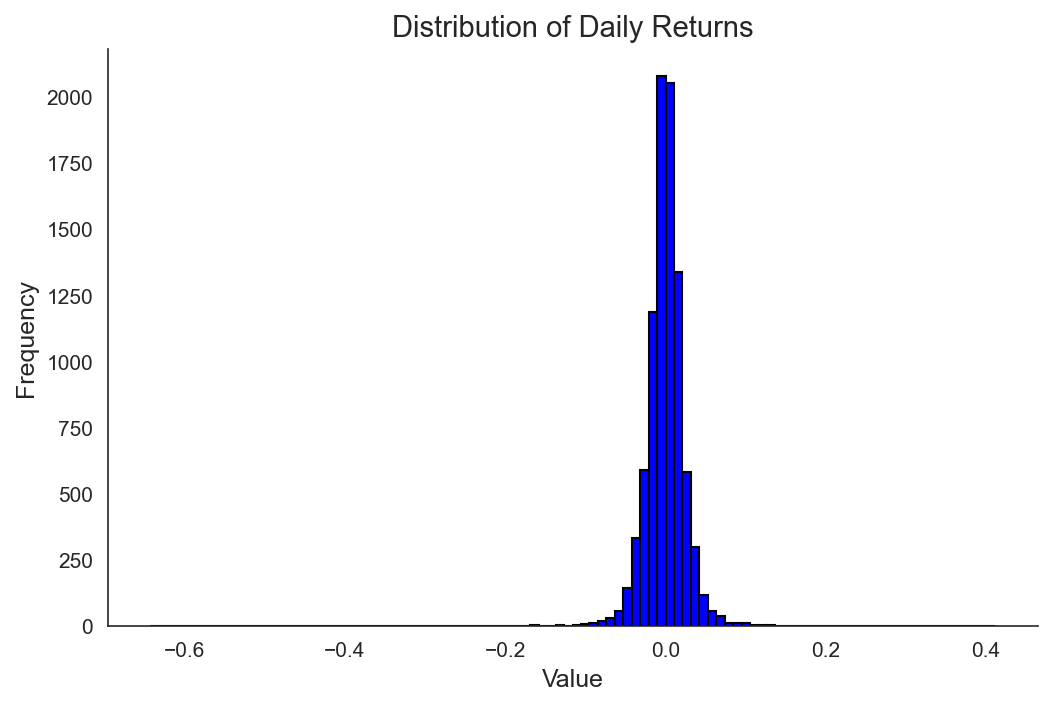

In [20]:
plotter.histogram_plot(returns, bins=100, title="Distribution of Daily Returns")

#### Volatility Clustering Check 

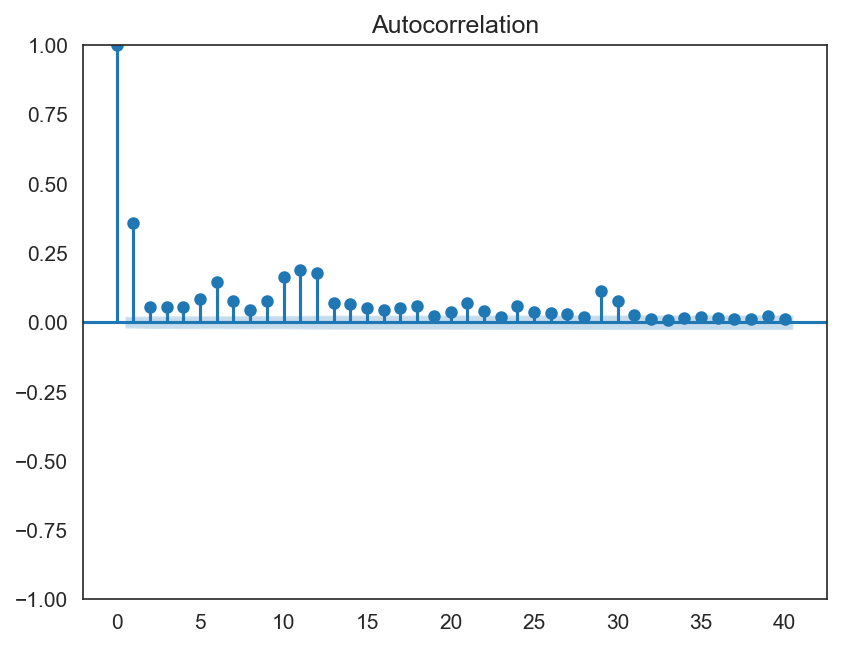

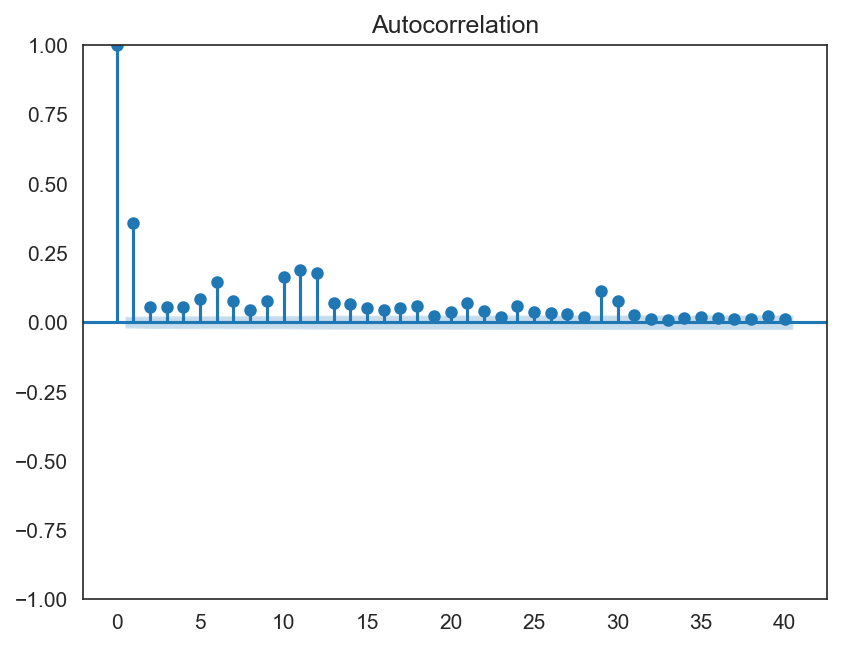

In [ ]:
plot_acf(returns**2, lags=40)